# Customer Churn Prediction & Customers Survival Analysis

In [19]:
import numpy as np#used for numerical operations, especially working with arrays, matrices, and mathematical functions
import pandas as pd#used for data manipulation and analysis—loading datasets, cleaning, and transforming data.
import matplotlib.pyplot as plt#used for plotting graphs and visualizations like line plots, bar plots, histograms, etc
import seaborn as sns#used for making attractive and informative statistical plots easily
sns.set_style('darkgrid')#adds a dark grid background to plots, making them easier to read

In [21]:
#read the cleaned dataset into a DataFrame (assumes CSV file is in the same folder)
df = pd.read_csv("Telco-Customer-Churn-Cleaned.csv")
#display the first few rows to verify successful loading
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,False,False,False,False,False,True,False
1,0,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,0,False,False,True,False,False,False,True
2,0,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,False,False,False,False,False,False,True
3,0,0,0,0,45,0,0,1,0,1,...,42.30,1840.75,0,False,False,True,False,False,False,False
4,1,0,0,0,2,1,0,0,0,0,...,70.70,151.65,1,True,False,False,False,False,True,False


In [9]:
#check if there are any missing (null) values in the entire dataframe
df.isnull().any().any()

False

## Model Building

In [12]:
#import functions for splitting dataset and hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
#import performance evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
#import SMOTE (Synthetic Minority Over-sampling Technique) to handle class imbalance
from imblearn.over_sampling import SMOTE
#import Random Forest Classifier algorithm from sklearn
from sklearn.ensemble import RandomForestClassifier

In [14]:
#split the dataset into train and test sets (80% train, 20% test)
#stratify on 'Churn' to keep the class distribution similar in both sets
#random_state is set for reproducibility of the split
train, test = train_test_split(df, test_size=0.2, random_state=111, stratify=df.Churn)

In [16]:
#select all column names except 'Churn' to be used as features (independent variables)
x = df.columns[df.columns != "Churn"]

#define the target variable (dependent variable)
y = "Churn"

#split the training data into features (train_x) and target (train_y)
train_x = train[x]    # training features
train_y = train[y]    # training target

#split the testing data into features (test_x) and target (test_y)
test_x = test[x]      # testing features
test_y = test[y]      # testing target

In [18]:
#function to train a classification model, evaluate performance, and visualize results
def churn_prediction(algo, training_x, training_y, testing_x, testing_y, cols, cf = 'coefficients'):

    #fit the model using training data
    algo.fit(training_x, training_y)

    #make predictions on the test data (labels)
    predictions = algo.predict(testing_x)

    #get predicted probabilities for ROC AUC curve (specifically for class 1)
    probabilities = algo.predict_proba(testing_x)[:, 1]

    #if specified cf = "coefficients", extract linear model coefficients
    if cf == "coefficients":
        coefficients = pd.DataFrame(algo.coef_.ravel())

    #if cf = "features", extract feature importances (for tree-based models)
    elif cf == "features":
        coefficients = pd.DataFrame(algo.feature_importances_)

    #create a dataframe from the column names passed as `cols`
    column_df = pd.DataFrame(cols)

    #combine coefficients and column names into a single summary dataframe
    coef_sumry = pd.merge(coefficients, column_df, left_index=True, right_index=True, how="left")

    #rename columns for readability
    coef_sumry.columns = ["coefficients", "features"]

    #sort features by importance in descending order
    coef_sumry = coef_sumry.sort_values(by="coefficients", ascending=False)

    #print model type
    print(algo)

    #print classification report showing precision, recall, f1-score etc.
    print("\n Classification report : \n", classification_report(testing_y, predictions))

    #print accuracy score of the model
    print("Accuracy   Score : ", accuracy_score(testing_y, predictions))

    #generate confusion matrix from actual vs predicted values
    conf_matrix = confusion_matrix(testing_y, predictions)

    #plot the confusion matrix as a heatmap
    plt.figure(figsize=(12, 12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt="d", annot=True, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    #calculate ROC AUC score (area under the curve)
    model_roc_auc = roc_auc_score(testing_y, probabilities)
    print("Area under curve : ", model_roc_auc, "\n")

    #get values for ROC curve plot
    fpr, tpr, thresholds = roc_curve(testing_y, probabilities)

    #plot ROC curve to visualize performance of classifier
    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label="AUC : %.3f" % model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # reference line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    #plot top features or coefficients as bar chart
    plt.subplot(212)
    sns.barplot(x=coef_sumry["features"], y=coef_sumry["coefficients"])
    plt.title('Feature Importances')
    plt.xticks(rotation="vertical")

    #display all plots
    plt.show()

### Hyperparameters Tuning

#### Grid 1: Selecting maximum number of features and estimators

In [25]:
#define a grid of hyperparameters to tune
param_grid1 = {
    'max_features': ['sqrt', 'log2', None],  # how many features to consider at each split (removed 'auto' as it's deprecated)
    'n_estimators': [300, 500, 700, 900, 1100, 1300]  # number of trees in the forest
}

#create a basic random forest model (will be tuned using grid search)
rf_model = RandomForestClassifier()

#use GridSearchCV to search over the defined grid of parameters
#cv=3 → 3-fold cross-validation to validate performance on unseen folds
#n_jobs=-1 → use all available cores to parallelize the grid search
#scoring='f1' → optimize based on F1 score (harmonic mean of precision and recall)
#verbose=1 → print progress of the grid search
grid1 = GridSearchCV(estimator=rf_model, param_grid=param_grid1, n_jobs=-1, cv=3, verbose=1, scoring='f1')

#fit the grid search on the training data to find the best parameter combination
grid1.fit(train_x, train_y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [300, 500, 700, 900, 1100, 1300]},
             scoring='f1', verbose=1)

In [27]:
#display the best estimator (model with best combination of hyperparameters) found by GridSearchCV
grid1.best_estimator_

RandomForestClassifier(max_features='log2', n_estimators=1300)

<Axes: xlabel='param_max_features', ylabel='param_n_estimators'>

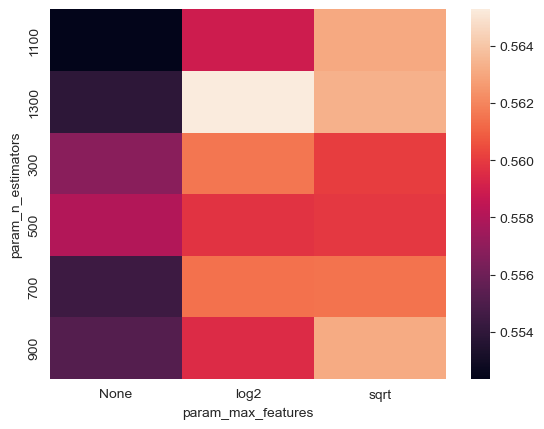

In [29]:
#store the cross-validation results from the GridSearchCV into a dataframe
dt = pd.DataFrame(grid1.cv_results_)

#convert max_features values to string so they can be used as column labels in the heatmap
dt.param_max_features = dt.param_max_features.astype(str)

#convert n_estimators values to string so they can be used as row labels in the heatmap
dt.param_n_estimators = dt.param_n_estimators.astype(str)

#create a pivot table to structure the mean test scores
#rows = different n_estimators values
#columns = different max_features values
#values = mean F1 score from cross-validation
table = pd.pivot_table(dt, values='mean_test_score', index='param_n_estimators', 
                       columns='param_max_features')

#plot a heatmap to visualize which parameter combinations performed better
sns.heatmap(table)

In [31]:
#display the best F1 score achieved by any combination of hyperparameters during GridSearchCV
grid1.best_score_

0.5652846007126516

#### Grid 2: Selecting max depth and split criterion

In [34]:
#define a grid of hyperparameters to tune for max depth and criterion
param_grid2 = {
    'max_features': ['sqrt'],                      # valid options now are: 'sqrt', 'log2', None or numeric
    'n_estimators': [1000, 1100, 1200],             # number of trees in the forest
    'criterion': ['entropy', 'gini'],              # splitting criteria - either 'gini' or 'entropy'
    'max_depth': [7, 9, 11, 13, 15, None]           # max depth of trees (None = grow trees until all leaves are pure)
}

#create a random forest model
rf_model = RandomForestClassifier()

#apply GridSearchCV to find the best parameter combination from the grid
#n_jobs=-1 → use all cores for parallel processing
#cv=3 → 3-fold cross-validation
#scoring='f1' → optimize based on F1 score (balance between precision & recall)
#verbose=1 → show progress of grid search
grid2 = GridSearchCV(estimator=rf_model, 
                     param_grid=param_grid2, 
                     n_jobs=-1, 
                     cv=3, 
                     verbose=1, 
                     scoring='f1')

#fit the model on training data with all combinations in the grid
grid2.fit(train_x, train_y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [7, 9, 11, 13, 15, None],
                         'max_features': ['sqrt'],
                         'n_estimators': [1000, 1100, 1200]},
             scoring='f1', verbose=1)

<Axes: xlabel='param_criterion', ylabel='param_max_depth'>

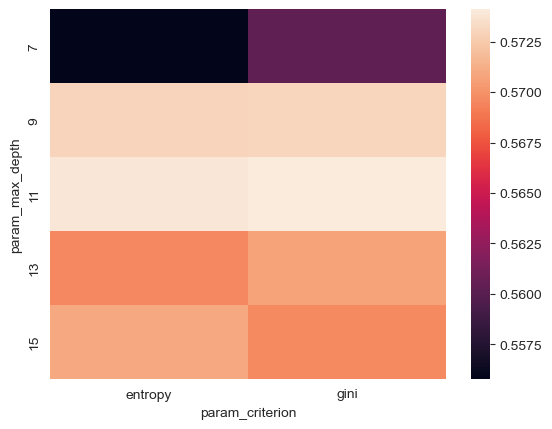

In [36]:
#convert grid2 results into a dataframe for analysis
dt = pd.DataFrame(grid2.cv_results_)

#create a pivot table from the grid results
#rows → max_depth values
#columns → criterion (gini, entropy)
#values → mean F1 score from cross-validation
table = pd.pivot_table(dt, values='mean_test_score', index='param_max_depth', 
                       columns='param_criterion')

#visualize the pivot table using a heatmap
#darker color → better F1 score
sns.heatmap(table)

<Axes: xlabel='param_n_estimators', ylabel='param_max_depth'>

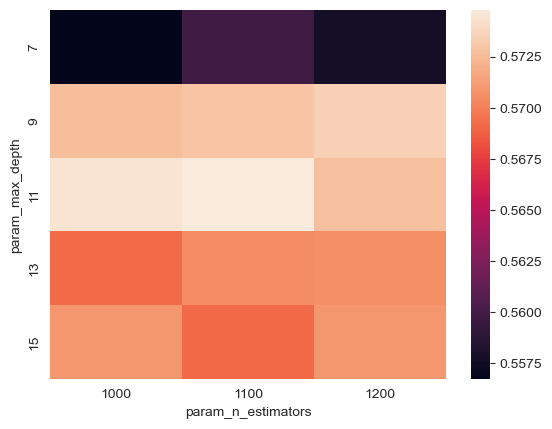

In [38]:
#create a pivot table from the grid search results dataframe
#rows → different values of max_depth
#columns → different values of n_estimators (number of trees)
#values → mean test F1 scores obtained during 3-fold cross-validation
table = pd.pivot_table(dt, values='mean_test_score', 
                       index='param_max_depth', 
                       columns='param_n_estimators')

#plot the pivot table as a heatmap for visual comparison
#helps in identifying which (max_depth, n_estimators) combination gave best performance
sns.heatmap(table)

In [40]:
#returns the best F1 score achieved during grid search cross-validation
#this is the highest mean_test_score across all parameter combinations tried in GridSearchCV
grid2.best_score_

0.575903477059096

In [42]:
#define another grid of hyperparameters to fine-tune the model further
param_grid2_2 = {
    'max_features': ['sqrt'],             # 'auto' is deprecated in new sklearn versions, use 'sqrt' instead
    'n_estimators': [950, 1000, 1050],    # number of trees in the forest
    'criterion': ['entropy'],             # use entropy as the criterion for splitting
    'max_depth': [10, 11, 12]             # max depth of the tree to control overfitting
}

#create a basic random forest model (which will be tuned using this grid)
rf_model = RandomForestClassifier()

#use GridSearchCV to find the best combination of parameters
#n_jobs = -1 → use all CPU cores
#cv = 3 → use 3-fold cross-validation
#verbose = 1 → show progress while training
#scoring = 'f1' → optimize the model based on F1 score
grid2_2 = GridSearchCV(estimator=rf_model, 
                       param_grid=param_grid2_2, 
                       n_jobs=-1, 
                       cv=3, 
                       verbose=1, 
                       scoring='f1')

#fit the model using training data
grid2_2.fit(train_x, train_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [10, 11, 12],
                         'max_features': ['sqrt'],
                         'n_estimators': [950, 1000, 1050]},
             scoring='f1', verbose=1)

In [44]:
#display the best model (i.e., the RandomForestClassifier with best combination of parameters from the grid)
grid2_2.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=1000)

In [46]:
#display the best F1-score achieved during grid search cross-validation
grid2_2.best_score_

0.5779698962343144

#### Grid 3: Selecting minimum samples leaf and split

In [61]:
#define the third grid of hyperparameters for further tuning of Random Forest model
param_grid3 = {
    'max_features': ['sqrt'],   # number of features to consider at every split ('sqrt' is valid instead of deprecated 'auto')
    'n_estimators': [1000],     # total number of trees to grow in the forest
    'criterion': ['entropy'],   # function to measure the quality of a split
    'max_depth': [10],          # maximum depth each decision tree can grow
    'min_samples_leaf': [1, 3, 5, 7],       # minimum number of samples required at a leaf node
    'min_samples_split': [2, 4, 6, 8]       # minimum number of samples required to split an internal node
}

#create a base random forest classifier model
rf_model = RandomForestClassifier(random_state=42)

#apply GridSearchCV to try all parameter combinations from param_grid3
#cv=3 → 3-fold cross-validation
#n_jobs=-1 → utilize all available cores for parallel processing
#verbose=1 → print progress while training
#scoring='f1' → choose model that gives best F1 score
grid3 = GridSearchCV(estimator=rf_model, 
                     param_grid=param_grid3, 
                     n_jobs=-1, 
                     cv=3, 
                     verbose=1, 
                     scoring='f1')

#fit the grid search model on training data to find best hyperparameter combination
grid3.fit(train_x, train_y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [10],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [1000]},
             scoring='f1', verbose=1)

In [62]:
grid3.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=6,
                       n_estimators=1000, random_state=42)

<Axes: xlabel='param_min_samples_split', ylabel='param_min_samples_leaf'>

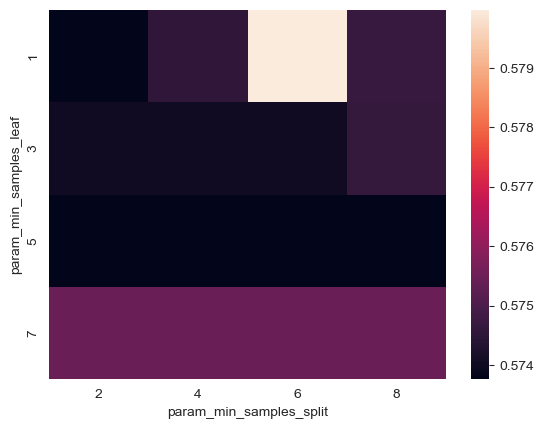

In [65]:
dt = pd.DataFrame(grid3.cv_results_)

table = pd.pivot_table(dt, values='mean_test_score', index='param_min_samples_leaf', 
                       columns='param_min_samples_split')
     
sns.heatmap(table)

In [67]:
grid3.best_score_

0.579978000424277

#### Grid 4: Selecting class weight

In [73]:
#define the fourth grid of hyperparameters to tune class weights (important for handling class imbalance)
param_grid4 = {
    'class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}],  # assigning more weight to class 1 (Churn = 1)
    'max_features': ['sqrt'],   # number of features to consider at each split ('auto' is deprecated, use 'sqrt')
    'n_estimators': [1000],     # number of trees to build
    'criterion': ['entropy'],   # splitting criterion
    'max_depth': [10],          # maximum depth of each tree
    'min_samples_leaf': [1],    # minimum number of samples required at a leaf node
    'min_samples_split': [8]    # minimum number of samples required to split an internal node
}

#create a base random forest model
rf_model = RandomForestClassifier(random_state=42)

#initialize GridSearchCV to search over the parameter grid
#cv=3 → 3-fold cross-validation
#n_jobs=-1 → use all available cores to speed up
#verbose=1 → print progress
#scoring='f1' → optimize for best F1 score
grid4 = GridSearchCV(estimator=rf_model,
                     param_grid=param_grid4,
                     n_jobs=-1,
                     cv=3,
                     verbose=1,
                     scoring='f1')

#fit the grid search model on the training data to find the best class_weight setting
grid4.fit(train_x, train_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}],
                         'criterion': ['entropy'], 'max_depth': [10],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [8], 'n_estimators': [1000]},
             scoring='f1', verbose=1)

In [75]:
grid4.best_estimator_

RandomForestClassifier(class_weight={0: 1, 1: 3}, criterion='entropy',
                       max_depth=10, min_samples_split=8, n_estimators=1000,
                       random_state=42)

<Axes: ylabel='param_class_weight'>

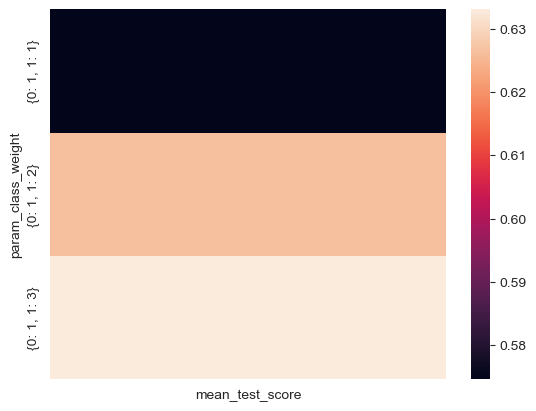

In [77]:
dt = pd.DataFrame(grid4.cv_results_)
dt.param_class_weight = dt.param_class_weight.astype(str)
table = pd.pivot_table(dt, values='mean_test_score', index='param_class_weight')
     
sns.heatmap(table)

In [79]:
grid4.best_score_

0.6330431043479453

### Final Model

In [84]:
#final tuned Random Forest model with all the best hyperparameters manually set
model = RandomForestClassifier(

    #enable bootstrap sampling when building trees (sampling with replacement)
    bootstrap=True,

    #disable cost-complexity pruning (default setting)
    ccp_alpha=0.0,

    #assign class weights to handle class imbalance (higher weight to class 1: churned customers)
    class_weight={0: 1, 1: 2},

    #use entropy (information gain) as the criterion for splitting
    criterion='entropy',

    #maximum depth of the trees (controls model complexity and overfitting)
    max_depth=10,

    #number of features to consider when looking for the best split
    # 'sqrt' is common practice for classification tasks
    max_features='sqrt',

    #allow trees to grow with no constraint on number of leaf nodes
    max_leaf_nodes=None,

    #do not sample a subset of rows for each tree (use full data for each tree)
    max_samples=None,

    #do not enforce minimum impurity decrease for node splits
    min_impurity_decrease=0.0,

    #minimum number of samples required to be at a leaf node
    min_samples_leaf=1,

    #minimum number of samples required to split an internal node
    min_samples_split=8,

    #do not enforce any minimum weighted fraction at leaf node
    min_weight_fraction_leaf=0.0,

    #number of trees in the forest
    n_estimators=1000,

    #number of parallel jobs to run (None → use one core)
    n_jobs=None,

    #do not use out-of-bag samples for model validation
    oob_score=False,

    #no fixed seed set (results may vary between runs)
    random_state=None,

    #disable model training progress messages
    verbose=0,

    #do not reuse previously fitted trees
    warm_start=False
)

RandomForestClassifier(class_weight={0: 1, 1: 2}, criterion='entropy',
                       max_depth=10, min_samples_split=8, n_estimators=1000)

 Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      1035
           1       0.59      0.66      0.62       374

    accuracy                           0.79      1409
   macro avg       0.73      0.74      0.74      1409
weighted avg       0.80      0.79      0.79      1409

Accuracy   Score :  0.78708303761533
Area under curve :  0.8485261825415278 



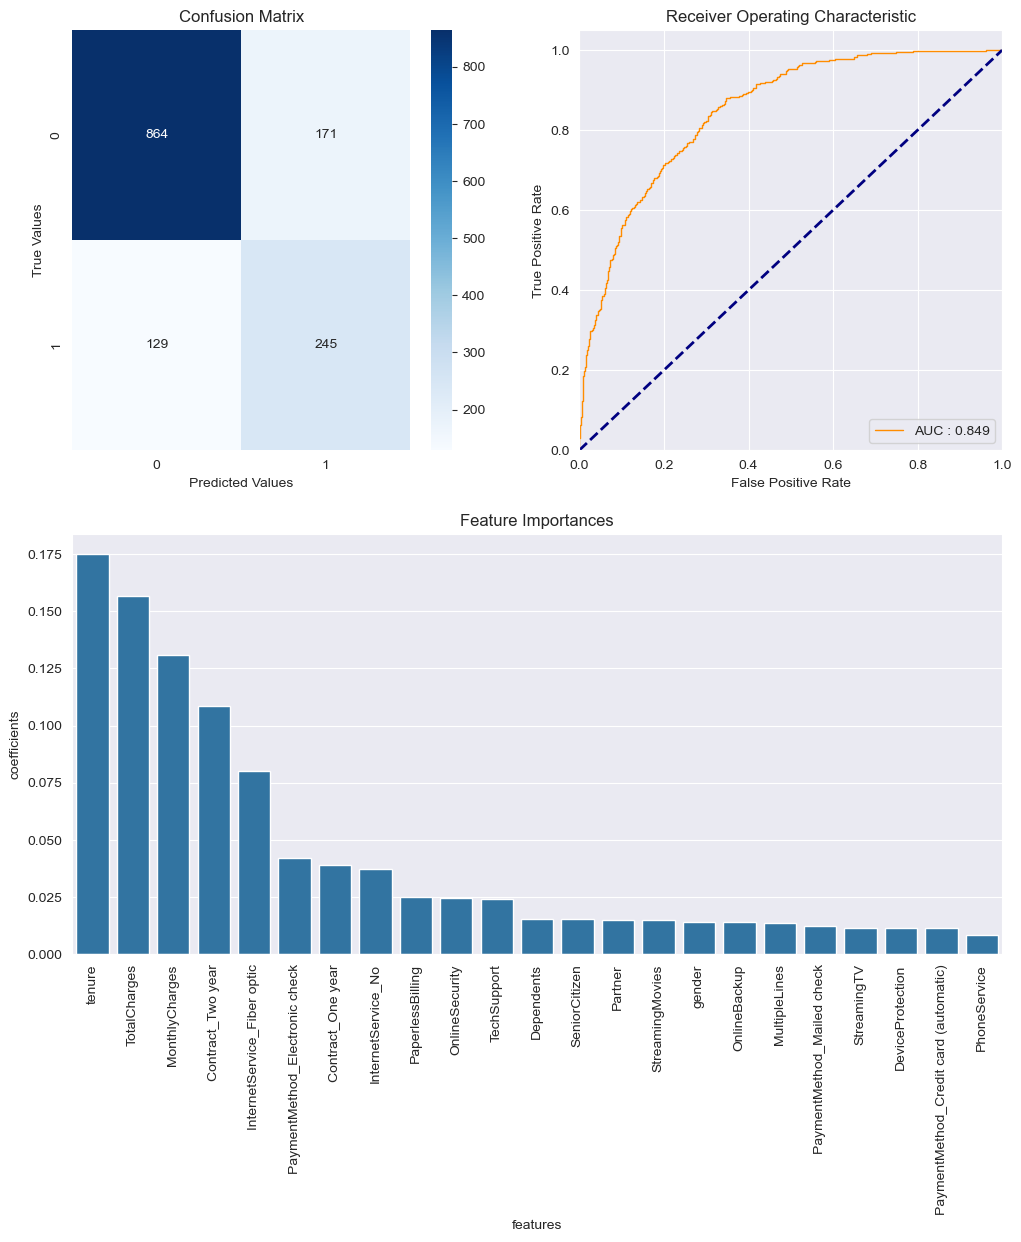

In [86]:
#apply the churn prediction function using the final tuned Random Forest model
churn_prediction(model, train_x, train_y, test_x, test_y, x,"features")

### Checking the model's performance on train data itself

In [95]:
#perform 5-fold cross-validation on the training set using the final tuned Random Forest model
train_scores = cross_val_score(model, train_x, train_y, cv=5, scoring='f1')
train_scores

array([0.60522273, 0.672     , 0.6200318 , 0.58278146, 0.64364207])

In [97]:
np.mean(train_scores)

0.6247356119849041

### Saving model

In [100]:
#import the pickle module which allows us to save Python objects to a file
import pickle
#save (serialize) the trained Random Forest model into a binary file named 'model.pkl'
#'wb' mode stands for "write binary"
pickle.dump(model, open('model.pkl', 'wb'))

## Explaining the model

In [105]:
!pip install eli5

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/10.7 MB 7.5 MB/s eta 0:00:02
   ----------- ---------------------------- 3.1/10.7 MB 8.0 MB/s eta 0:00:01
   ------------------ --------------------- 5.0/10.7 MB 8.2 MB/s eta 0:00:01
   ------------------------ --------------- 6.6/10.7 MB 8.2 MB/s eta 0:00:01
   ------------------------------ --------- 8.1/10.7 MB 8.1 MB/s eta 0:00:01
   ------------------------------------ --- 9.7/10.7 MB 8.1 MB/s eta 0:00:01
   ---------------------------------------- 10.7/10.7 MB 7.8 MB/s eta 0:00:00


DEPRECATION: Loading egg at d:\softwares\an\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


### Visualizing how the partial dependance plots look for top features

#### Internet Service: Fiber Optic

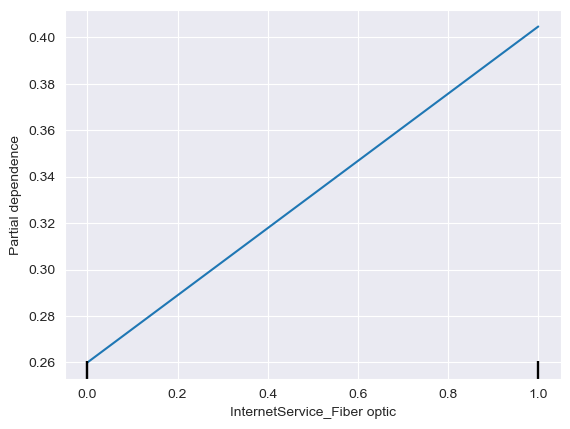

In [137]:
#from sklearn.inspection, import the PartialDependenceDisplay to visualize how a feature affects model predictions
from sklearn.inspection import PartialDependenceDisplay

#plot the partial dependence plot for the selected feature using test data and trained model
#this shows how predictions change as the value of 'InternetService_Fiber optic' changes
PartialDependenceDisplay.from_estimator(
    model,                 #our trained Random Forest model
    test_x,                #features from test data
    features=['InternetService_Fiber optic'],  #the specific feature we want to analyze
    kind='average',        #shows the average effect of the feature on predictions
    grid_resolution=20     #number of grid points to evaluate
)

#display the plot
plt.show()

#### Payment Method: Mailed Check

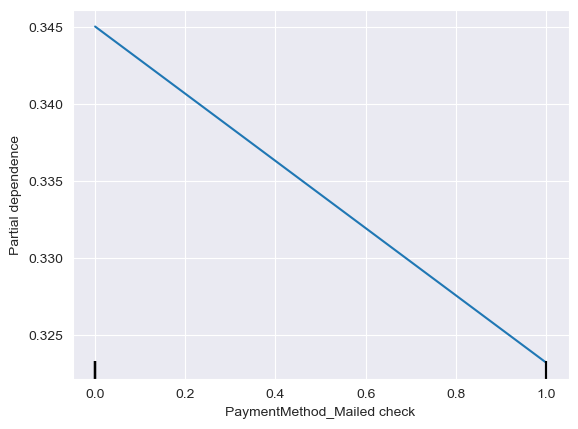

In [139]:
#plot the partial dependence for 'PaymentMethod_Mailed check'
#this shows how the model’s predicted probability changes with this feature
PartialDependenceDisplay.from_estimator(
    model,                                 #our trained random forest model
    test_x,                                #feature dataset (test set)
    features=['PaymentMethod_Mailed check'],  #feature to analyze
    kind='average',                        #shows average marginal effect on prediction
    grid_resolution=20                     #granularity of points used in plot
)

#display the plot
plt.show()

#### Monthly Charges

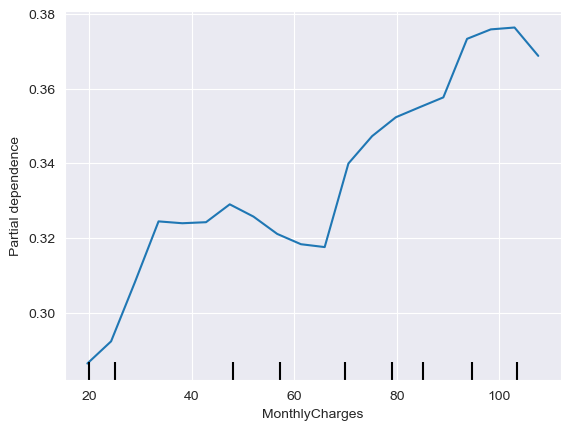

In [142]:
#plot the partial dependence of 'MonthlyCharges' feature
#this will show how the model’s predictions vary with different values of MonthlyCharges
PartialDependenceDisplay.from_estimator(
    model,                       #trained random forest model
    test_x,                      #test dataset (independent variables)
    features=['MonthlyCharges'],#target feature for PDP plot
    kind='average',              #plot the average effect on prediction
    grid_resolution=20           #number of equally spaced points to evaluate
)

#show the generated plot
plt.show()

#### Total Charges

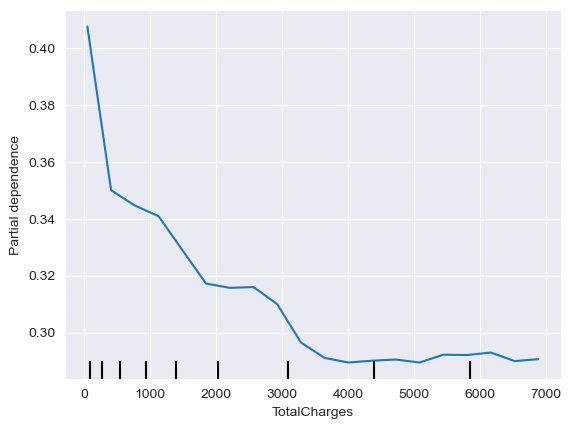

In [146]:
#Import the PartialDependenceDisplay class from sklearn for PDP visualizations
from sklearn.inspection import PartialDependenceDisplay

#Plot the Partial Dependence Plot (PDP) for the 'TotalCharges' feature
#This helps visualize the marginal effect of 'TotalCharges' on churn prediction
PartialDependenceDisplay.from_estimator(
    model,                       #your trained Random Forest model
    test_x,                      #test data (independent variables)
    features=['TotalCharges'],   #feature for which PDP needs to be plotted
    kind='average',              #type of PDP (average effect across all samples)
    grid_resolution=20           #number of grid points for evaluating PDP
)

#display the plot
plt.show()

#### Contract - Two years

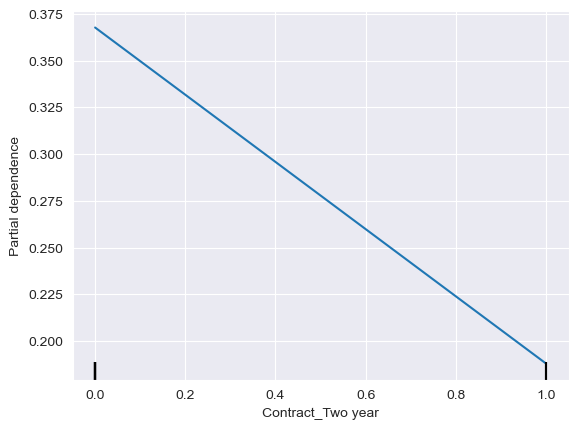

In [149]:
#Import PartialDependenceDisplay from sklearn to visualize feature influence
from sklearn.inspection import PartialDependenceDisplay

#Plot the Partial Dependence Plot (PDP) for 'Contract_Two year'
#This shows how the model's churn prediction changes with this feature
PartialDependenceDisplay.from_estimator(
    model,                          #trained Random Forest model
    test_x,                         #test dataset (features only)
    features=['Contract_Two year'],#feature to analyze PDP for
    kind='average',                 #average PDP across all samples
    grid_resolution=20             #granularity of PDP curve
)

#display the plot
plt.show()

#### Tenure

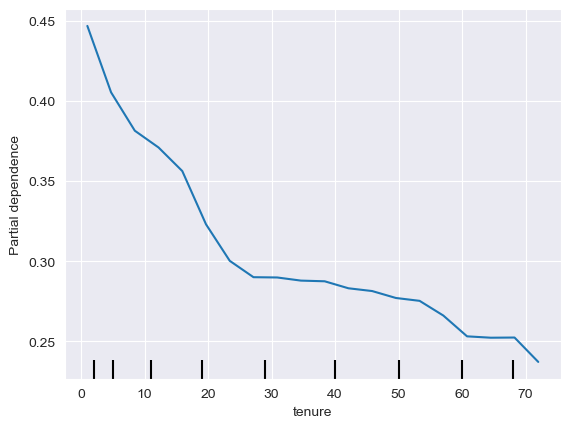

In [152]:
#Import the PartialDependenceDisplay module from sklearn to visualize feature impact
from sklearn.inspection import PartialDependenceDisplay

#Create PDP for the feature 'tenure' to see how it influences churn probability
PartialDependenceDisplay.from_estimator(
    model,             #final trained Random Forest model
    test_x,            #test features on which PDP will be plotted
    features=['tenure'], #the feature for which PDP is generated
    kind='average',    #type of PDP plot (average effect across data)
    grid_resolution=20 #number of points to use on x-axis (higher = smoother curve)
)

#display the plot
plt.show()

### Gauge Chart 

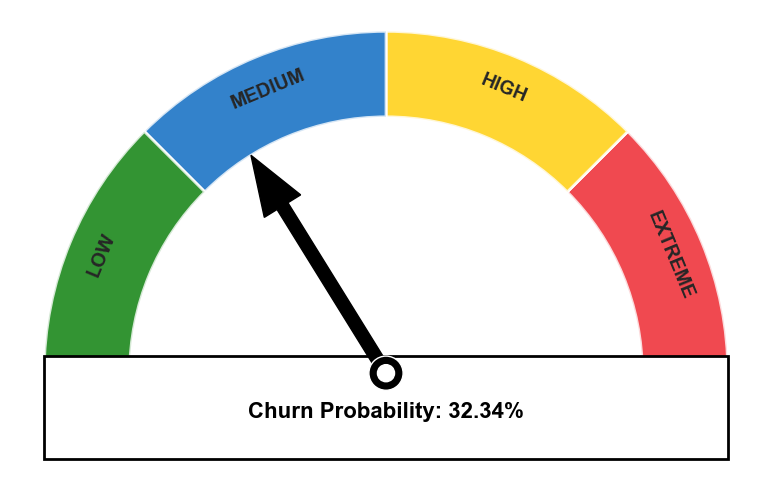

In [181]:
#required imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Rectangle

#function to return angular ranges and label positions
def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1:]
    mid_points = start + ((end - start)/2.)
    return np.c_[start, end], mid_points

#function to rotate label text based on angle
def rot_text(ang): 
    return ang - 90

#main gauge function to visualize churn probability using a semi-circular dial
def gauge(labels=['LOW','MEDIUM','HIGH','EXTREME'],
          colors=['#007A00','#0063BF','#FFCC00','#ED1C24'], 
          Probability=1.0, fname=False):

    #reverse colors and labels for left-to-right mapping (LOW to EXTREME)
    colors = colors[::-1]
    labels = labels[::-1]
    N = len(labels)

    #initialize figure and axis
    fig, ax = plt.subplots(figsize=(10, 5))
    
    #get angular ranges and midpoint angles for labeling
    ang_range, mid_points = degree_range(N)

    #plot colored arcs and white sectors underneath
    patches = []
    for ang, c in zip(ang_range, colors): 
        patches.append(Wedge((0, 0), 0.4, *ang, facecolor='white', lw=2))
        patches.append(Wedge((0, 0), 0.4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.8))
    
    for p in patches:
        ax.add_patch(p)

    #add category labels (LOW, MEDIUM, etc.)
    for mid, lab in zip(mid_points, labels): 
        ax.text(0.36 * np.cos(np.radians(mid)), 
                0.36 * np.sin(np.radians(mid)), 
                lab, ha='center', va='center', 
                fontsize=14, fontweight='bold', rotation=rot_text(mid))

    #add rectangular banner below gauge
    banner = Rectangle((-0.4, -0.1), 0.8, 0.12, facecolor='white', edgecolor='black', lw=2)
    ax.add_patch(banner)

    #write churn probability value inside the banner
    ax.text(0, -0.045, f'Churn Probability: {np.round(Probability * 100, 2)}%', 
            ha='center', va='center', fontsize=16, fontweight='bold', color='black')

    #calculate arrow angle (reversed scale: higher probability → left)
    pos = (1 - Probability) * 180
    
    #draw arrow pointer indicating predicted probability
    ax.arrow(0, 0, 0.23 * np.cos(np.radians(pos)), 0.23 * np.sin(np.radians(pos)),
             width=0.015, head_width=0.05, head_length=0.07, fc='black', ec='black')

    #draw central dial knob
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='black'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='white', zorder=11))

    #hide axes, ticks, and frame
    ax.set_aspect('equal')
    ax.axis('off')
    plt.tight_layout()

    #save if filename provided, otherwise show
    if fname:
        fig.savefig(fname, dpi=300)
    plt.show()

#call the gauge with model's predicted churn probability for 1st test sample
gauge(Probability=model.predict_proba(test_x.iloc[0:1])[0, 1])

## Survival Regression 

In [ ]:
!pip install lifelines

In [13]:
#load necessary survival analysis model from lifelines
from lifelines import CoxPHFitter

In [23]:
#use existing cleaned dataset and store it in a separate variable for clarity
regression_df = df.copy()

In [33]:
#initialize the Cox Proportional Hazards model
cph = CoxPHFitter()

#fit the model using tenure as time variable and churn as event indicator
#tenure → how long customer has stayed
#Churn → 1 if customer has churned, 0 otherwise
cph.fit(regression_df, duration_col='tenure', event_col='Churn')

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

<Axes: xlabel='log(HR) (95% CI)'>

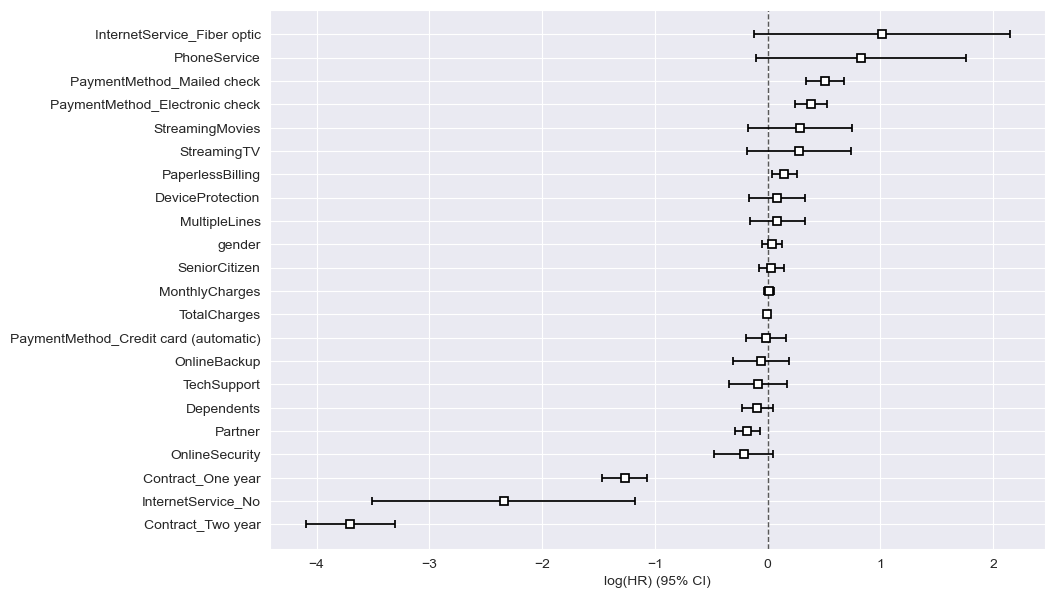

In [35]:
#visualize the effect of each feature on churn risk (hazard ratio >1 = increases risk, <1 = reduces risk)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,7))
cph.plot(ax = ax)

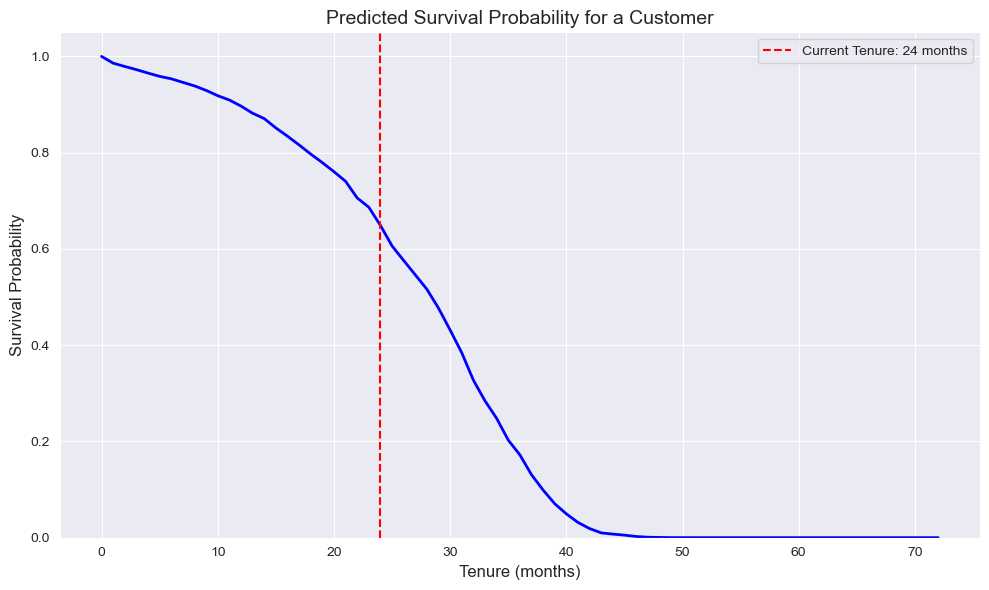

In [58]:
#select a random test customer from the cleaned dataset
test_customer = df.sample(1)

#predict survival probability for this customer over time (for each tenure month)
#this gives: P(customer is still active at month X)
survival_probs = cph.predict_survival_function(test_customer)

#begin plotting survival curve
plt.figure(figsize=(10, 6))

#plot the actual survival probabilities (tenure on x-axis, survival prob on y-axis)
plt.plot(survival_probs.index, survival_probs.values.flatten(), color='blue', linewidth=2)

#mark the customer's current tenure on the graph (dashed red line)
current_tenure = test_customer['tenure'].values[0]
plt.axvline(x=current_tenure, color='red', linestyle='--', label=f'Current Tenure: {int(current_tenure)} months')

#set title, axis labels, grid and legend
plt.title("Predicted Survival Probability for a Customer", fontsize=14)
plt.xlabel("Tenure (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()

#show the final plot
plt.show()

## Customer Lifetime Value

In [48]:
#function to calculate Lifetime Value (LTV) of a single customer based on survival probabilities and monthly charges
def LTV(customer_info):
    #predict survival probabilities over time for the given customer using the Cox model
    survival_probs = cph.predict_survival_function(customer_info).reset_index()
    survival_probs.columns = ['Tenure', 'Probability']  #rename columns for clarity
    
    #find the maximum tenure where survival probability is still above a threshold (e.g., 10%)
    #this is used as a proxy for expected customer lifetime
    expected_life = survival_probs.Tenure[survival_probs.Probability > 0.1].max()
    
    #calculate LTV by multiplying expected life with monthly charges for that customer
    ltv_value = expected_life * customer_info['MonthlyCharges'].values[0]
    
    return ltv_value

In [52]:
#create a sample customer row
test_id = regression_df.sample(1)
#calculate and print the LTV for a sample customer
print('LTV of the selected customer is:', LTV(test_id), 'dollars.')

LTV of the selected customer is: 1369.35 dollars.


## Retention Strategy Simulation

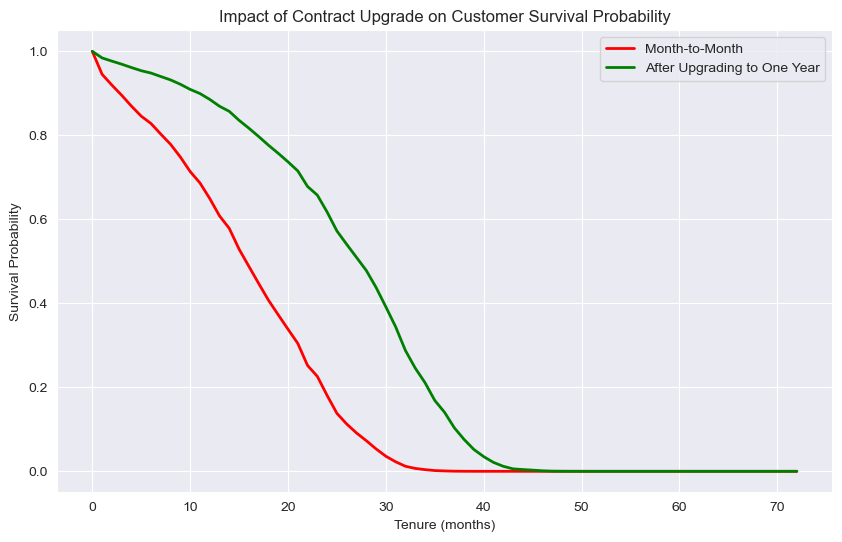

In [66]:
#identify a customer on 'Month-to-month' by checking that both other contract types are 0
month_to_month_mask = (df['Contract_One year'] == 0) & (df['Contract_Two year'] == 0)
original_customer = df[month_to_month_mask].sample(1, random_state=42)

#simulate upgrading this customer to a One year contract
modified_customer = original_customer.copy()
modified_customer['Contract_One year'] = 1
modified_customer['Contract_Two year'] = 0  #ensure it's still one year only

#predict survival functions
survival_original = cph.predict_survival_function(original_customer)
survival_modified = cph.predict_survival_function(modified_customer)

#plotting both curves
plt.figure(figsize=(10, 6))
plt.plot(survival_original.index, survival_original.values, label="Month-to-Month", color='red', linewidth=2)
plt.plot(survival_modified.index, survival_modified.values, label="After Upgrading to One Year", color='green', linewidth=2)

plt.title("Impact of Contract Upgrade on Customer Survival Probability")
plt.xlabel("Tenure (months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()